In [1]:
import pandas as pd
import torch
import json
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import f1_score,accuracy_score,recall_score
import traceback



import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
namedic2 = {}
namedic2['baseline_pred'] = 'LR'
namedic2['randomforest_pred'] = 'RF'
namedic2['caleq_pred'] = 'CALEQ'
namedic2['rocv_pred'] = 'ROC'
namedic2['adv_rew_pred'] = 'SREW'
namedic2['lfr_pred'] = 'LFR'
namedic2['adv_deb_pred'] = 'ADDEB'
namedic2['egr_pred'] = 'EGR'
namedic2['gsr_pred'] = 'GSR'
namedic2['DRO_pred'] = 'MDRO'
namedic2['OG_DRO_pred'] = 'DRO'
namedic2['ARL_pred'] = 'ARL'
namedic2['Softweights_pred'] = 'SOFT'
namedic2['private_pred'] = 'PRIV'
def algnames(name):
    return namedic2[name]

In [4]:
list1 = ['baseline_pred','randomforest_pred']
    
list2 = ['adv_rew_pred',
             'adv_deb_pred',
             'lfr_pred',
             'caleq_pred_weighted',
             'rocv_pred_average_odds',
             'egr_pred_EqualizedOdds',
             'gsr_pred_EqualizedOdds']
    
list3 = ['Softweights_pred','private_pred', 'DRO_pred']
    
list4 = ['ARL_pred', 'OG_DRO_pred']

In [5]:
def getresultsdic(adult_df,ds):
    results = {}
    ground_truth = adult_df['ground_truth']
    patt = ""
    
    if ds =='law_school':
        patt = 'sex'
    else:
        patt = 'SEX'
    ground_truth.index = adult_df[patt]
    import traceback
    for out in list1+list2+list3+list4:
        if 'Accuracy' not in results:
            results['Accuracy'] = {}
        try:
            out_pred = adult_df[out]
            try:
                out_pred.index = adult_df['true_'+patt]
                results['Accuracy'][out] = accuracy_score(list(ground_truth), list(out_pred))
            except:
                out_pred.index = adult_df[patt]
                results['Accuracy'][out] = accuracy_score(list(ground_truth), list(out_pred))
        except:
            results['Accuracy'][out] = None

        if 'Equal Odds Difference' not in results:
            results['Equal Odds Difference'] = {}
        try: 
            out_pred = adult_df[out]
            try:
                out_pred.index = adult_df['true_'+patt]
                results['Equal Odds Difference'][out] = metrics.average_odds_difference(ground_truth,out_pred,prot_attr='true_'+patt, priv_group = 'Male', pos_label = 1) 
            except:
                out_pred.index = adult_df[patt]
                results['Equal Odds Difference'][out] = metrics.average_odds_difference(ground_truth,out_pred,prot_attr=patt, priv_group = 'Male', pos_label = 1) 
        except:
            results['Equal Odds Difference'][out] = None
    return results


# 2 line plots per metric - synthetic
# histograms for case studies 

def get_df(results, percentage, version):

    list1 = ['baseline_pred','randomforest_pred']

    list2 = ['adv_rew_pred',
                 'adv_deb_pred',
                 'lfr_pred',
                 'caleq_pred_weighted',
                 'rocv_pred_average_odds',
                 'egr_pred_EqualizedOdds',
                 'gsr_pred_EqualizedOdds']

    list3 = ['Softweights_pred','private_pred', 'DRO_pred']

    list4 = ['ARL_pred', 'OG_DRO_pred']

    DF_list = []

    for metric in results:
        algset = {}
        for alg in results[metric]:
            entry = {}
            entry['metric'] = metric
            if len(alg.split('_pred'))>0:
                if alg.split('_pred')[0]+'_pred' not in algset:
                    algset[alg.split('_pred')[0]+'_pred']=[]
                algset[alg.split('_pred')[0]+'_pred'].append(results[metric][alg])
                entry['algorithm'] = algnames(alg.split('_pred')[0]+'_pred')
                try:
                    entry['value'] = np.mean(algset[alg.split('_pred')[0]+'_pred'])
                except:
                    entry['value'] = None

            else:
                entry['algorithm'] = algnames(alg)
                entry['value'] = results[metric][alg]
            if alg in list1:
                entry['Constraints'] = 'No constraints'
            if alg in list2:
                entry['Constraints'] = 'True protected attributes'
            if alg in list3:
                entry['Constraints'] = 'Noisy protected attributes'
            if alg in list4:
                entry['Constraints'] = 'No protected attributes'

            DF_list.append(entry)

    resultsdf = pd.DataFrame(DF_list)
    resultsdf = resultsdf.drop_duplicates(subset=['metric', 'algorithm'], keep='last')
    
    resultsdf['percentage'] = percentage
    resultsdf['version'] = version

    df_temps = []
    for group, df_group in resultsdf.groupby('metric'):
        df_group['pct'] = 100 * (1 - df_group.iloc[0].value / df_group.value)
        df_group['diff'] = df_group.value - df_group.iloc[0].value
        df_temps.append(df_group)
        
    return pd.concat(df_temps)


# ACSPublicCov

In [6]:
path = 'data/datasets/law_school/'
pcov_df = pd.read_csv(path+'test.csv',header=None)
pcov_df.columns = ['zfygpa', 'zgpa', 'DOByr', 'weightedlsatugpa', 'clustertier',
           'familyincome', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race',
           'pass_bar']
pcov_df['ground_truth'] = pd.Categorical(pcov_df['pass_bar']).codes
pcov_df.drop('pass_bar',axis=1,inplace=True)

In [7]:
pcov_df

,zfygpa,zgpa,DOByr,weightedlsatugpa,clustertier,familyincome,lsat,ugpa,isPartTime,sex,race,ground_truth
0,1.05,1.20,69.0,793.684190,3.0,5.0,40.0,3.2,No,Female,White,1
1,1.62,1.61,69.0,797.894717,5.0,4.0,39.0,3.4,No,Female,White,1
2,0.17,0.43,69.0,777.894717,3.0,3.0,39.0,3.2,No,Male,Other,1
3,-0.59,-0.76,67.0,780.526298,4.0,3.0,36.0,3.7,No,Male,White,1
4,-0.36,-1.17,63.0,461.052622,1.0,2.0,24.0,2.4,No,Male,Black,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5306,-1.23,-0.68,67.0,683.157879,5.0,2.0,33.0,3.2,No,Female,White,1
5307,1.22,0.81,71.0,869.473663,3.0,5.0,41.0,3.8,No,Male,White,0
5308,0.56,-0.35,66.0,700.526298,3.0,3.0,36.0,2.9,Yes,Male,White,1
5309,0.69,0.78,69.0,855.263136,5.0,4.0,42.0,3.5,No,Female,White,1


In [8]:
for file in os.listdir(path+'preds/'):
    # check only text files
    try:
        if file.endswith('.json'):
            f = open(path+'preds/'+file)
            items = json.load(f)
            f.close()
            cname = file.split('.')[0]
            pcov_df[cname]=items
        if file.endswith('.pt') and 'model' not in file:
            items = torch.load(path+'preds/'+file)
            cname = file.split('.')[0]
            pcov_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]
    except:
        traceback.print_exc()
        print('Error in', file)

In [9]:
results = getresultsdic(pcov_df,ds='law_school')
df_temps = get_df(results,0,0)
df_temps.sort_values(by="algorithm")#, key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

,metric,algorithm,value,Constraints,percentage,version,pct,diff
17,Equal Odds Difference,ADDEB,0.008520,True protected attributes,0,0,125.947769,0.010730
3,Accuracy,ADDEB,0.828846,True protected attributes,0,0,-0.068151,-0.000565
26,Equal Odds Difference,ARL,-0.021239,No protected attributes,0,0,89.591701,-0.019028
12,Accuracy,ARL,0.836001,No protected attributes,0,0,0.788288,0.006590
19,Equal Odds Difference,CALEQ,-0.011610,True protected attributes,0,0,80.958652,-0.009399
5,Accuracy,CALEQ,0.829034,True protected attributes,0,0,-0.045424,-0.000377
13,Accuracy,DRO,0.196761,No protected attributes,0,0,-321.531100,-0.632649
27,Equal Odds Difference,DRO,0.000000,No protected attributes,0,0,inf,0.002211
21,Equal Odds Difference,EGR,-0.000424,True protected attributes,0,0,-421.685573,0.001787
7,Accuracy,EGR,0.829787,True protected attributes,0,0,0.045382,0.000377


Accuracy


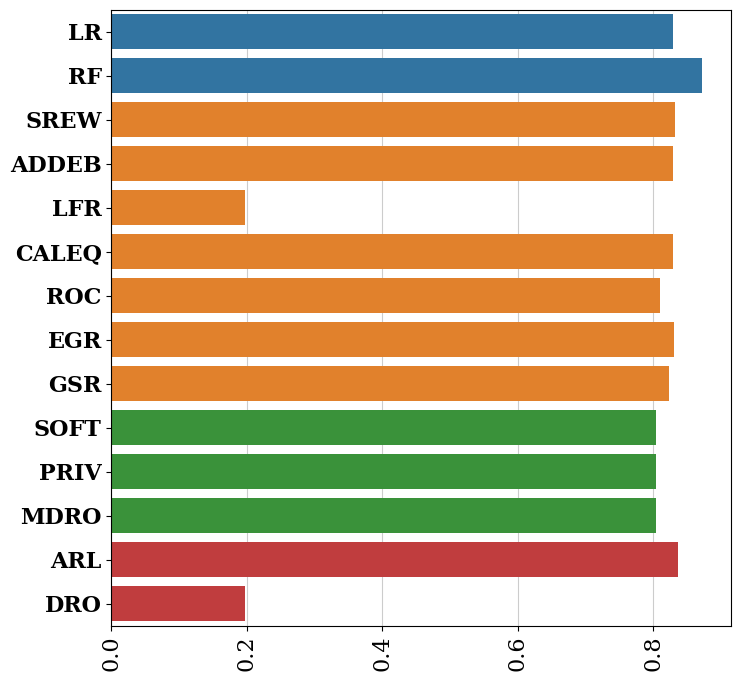

Equal Odds Difference


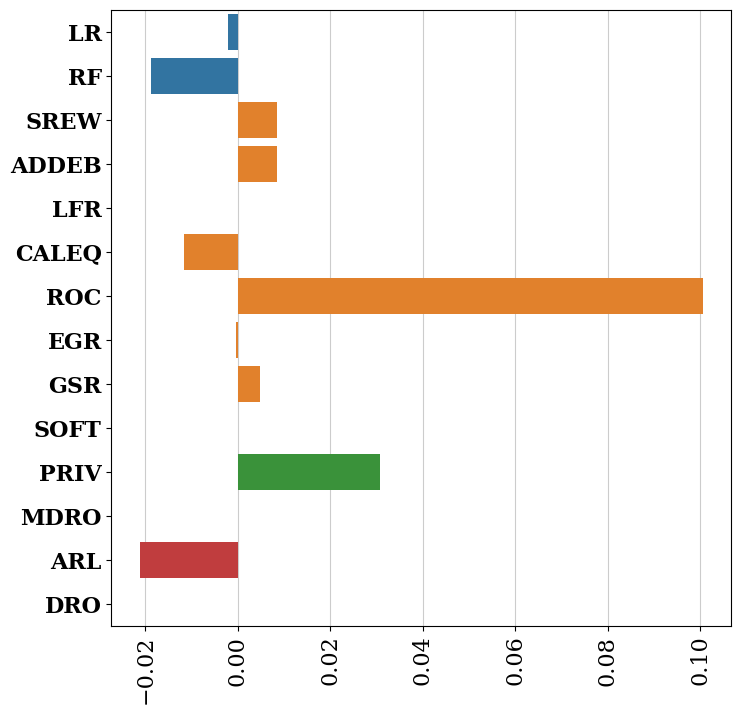

In [10]:
mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42


gdic = {}

for group, df_group in df_temps.groupby('metric'):
    hue_order = ['No constraints','True protected attributes','Noisy protected attributes','No protected attributes']
#     df_group.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df_group = df_group.dropna()
    ax = sns.barplot(data=df_group, y='algorithm', x='value', hue='Constraints',dodge=False,hue_order=hue_order)
    
#     plt.title(group,fontsize=18,weight='bold')
    
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(False,which='both')
    
#     if group in ['F1 Score', 'Accuracy','Disparate Impact Ratio']:
#         plt.axvline(x=1,linestyle ='--', color='black')
#     else:
#         plt.axvline(x=0,linestyle ='--', color = 'black')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)

    ax.get_legend().remove()
    ax.set_axisbelow(True)
    plt.xlabel(None)
    plt.ylabel(None)
#     plt.xlabel(group)
    plt.xticks(rotation = 90) 
    plt.yticks(weight='bold')
    
#     for spine in ('left','right'): # 'bottom', 'left'): 
#         plt.gca().spines[spine].set_visible(False)

#     plt.xscale("symlog")
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    print(group)
    plt.savefig('Plots/law_school_casestudy__'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")

    plt.show()

In [32]:
reslist = []
_percentages =  [[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9]]
for percentages in _percentages:
    for version in np.arange(10):
        try:
            dirc = path+('synthetic/gender_flip_labels{}_version{}/'.format(percentages[0],version))

            pcov_df = pd.read_csv(dirc+'test.csv',header=None)
            pcov_df.columns = ['zfygpa', 'zgpa', 'DOByr', 'weightedlsatugpa', 'clustertier',
                               'familyincome', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race','pass_bar']
            pcov_df['ground_truth'] = pd.Categorical(pcov_df['pass_bar']).codes
            pcov_df.drop('pass_bar',axis=1,inplace=True)
            
            for file in os.listdir(path+'preds/'):
                # check only text files
                    if file.endswith('.json'):
                        try:
                            f = open(dirc+'preds/'+file)
                            items = json.load(f)
                            f.close()
                            cname = file.split('.')[0]
                            pcov_df[cname]=items
                        except:
                            pass
                    if file.endswith('.pt') and 'model' not in file:
                        try:
                            items = torch.load(dirc+'preds/'+file)
                            cname = file.split('.')[0]
                            pcov_df[cname]=[int(i) for i in items.flatten().cpu().numpy()]
                        except:
                            traceback.print_exc()

            tg = json.load(open(dirc+'ogtestlabels.json'))
            pcov_df['true_sex'] = tg

            results = getresultsdic(pcov_df,ds='law_school')
            reslist.append(get_df(results,percentages[0],version))
        except:
            traceback.print_exc()
            print('error in ',dirc)

In [33]:
groupsizedf = pd.concat(reslist)

In [34]:
# groupsizedf = pd.concat([df_temps, groupsizedf])

In [35]:
groupsizedf

,metric,algorithm,value,Constraints,percentage,version,pct,diff
0,Accuracy,LR,0.830320,No constraints,0.1,0,0.000000,0.000000
1,Accuracy,RF,0.871940,No constraints,0.1,0,4.773218,0.041620
2,Accuracy,SREW,0.830697,True protected attributes,0.1,0,0.045341,0.000377
3,Accuracy,ADDEB,0.829567,True protected attributes,0.1,0,-0.090806,-0.000753
4,Accuracy,LFR,0.193032,True protected attributes,0.1,0,-330.146341,-0.637288
...,...,...,...,...,...,...,...,...
23,Equal Odds Difference,SOFT,0.000000,Noisy protected attributes,0.9,9,-inf,-0.017892
24,Equal Odds Difference,PRIV,0.008685,Noisy protected attributes,0.9,9,-106.022450,-0.009208
25,Equal Odds Difference,MDRO,0.000000,Noisy protected attributes,0.9,9,-inf,-0.017892
26,Equal Odds Difference,ARL,0.025125,No protected attributes,0.9,9,28.785369,0.007232


In [36]:
# tempdf1 = groupsizedf[groupsizedf['algorithm'].isin(['SREW','LFR'])].groupby(['percentage','version','metric']).agg('mean').reset_index()
# tempdf1['Constraints'] = 'True protected attributes'
# tempdf1['algorithm'] = 'PRE'
# tempdf1

In [37]:
# tempdf2 = groupsizedf[groupsizedf['algorithm'].isin(['ADDEB','EGR','GSR'])].groupby(['percentage','version','metric']).agg('mean').reset_index()
# tempdf2['Constraints'] = 'True protected attributes'
# tempdf2['algorithm'] = 'IN'
# tempdf2

In [38]:
# tempdf3 = groupsizedf[groupsizedf['algorithm'].isin(['CALEQ','ROC'])].groupby(['percentage','version','metric']).agg('mean').reset_index()
# tempdf3['Constraints'] = 'True protected attributes'
# tempdf3['algorithm'] = 'POST'
# tempdf3

In [39]:
# tempdf4 = groupsizedf[groupsizedf['Constraints']!='True protected attributes']

# groupsizedf = pd.concat([tempdf1,tempdf2,tempdf3,tempdf4])

In [40]:
# groupsizedf

In [41]:
# mpl.rcParams['figure.figsize'] = (8, 8)
# plt.rcParams["font.family"] = 'DejaVu Serif'
# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.alpha'] = 1
# plt.rcParams['grid.color'] = "#cccccc"
# plt.rcParams["pdf.fonttype"] = 42
# plt.rcParams["ps.fonttype"] = 42
# algs = set(groupsizedf['algorithm'])

# for group,df_group in groupsizedf.groupby('metric'):
#     print(group)
#     df_group = df_group.reset_index(drop=True)
#     df_group.sort_values(by="algorithm")#, key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
# #     df_group.replace([np.inf, -np.inf], np.nan, inplace=True)
# #     df_group = df_group.dropna()
        
# #     if group in ['F1 Score', 'Accuracy','Disparate Impact Ratio']:
# #         plt.axvline(x=1,linestyle ='--', color='black')
# #     else:
# #         plt.axvline(x=0,linestyle ='--', color = 'black')

            
#     ax = sns.violinplot(data=df_group, y="algorithm", x="value", hue="Constraints", dodge=False)
# #     plt.title(group,fontsize=18,weight='bold')
#     plt.legend(loc=(1.05, 0))
#     plt.xlabel(None)
#     plt.ylabel(None)
#     plt.xticks(rotation=90)#,weight='bold')
#     plt.yticks(weight='bold')

    
#     ax.xaxis.grid(True,which='both')
#     ax.yaxis.grid(True,which='both')
#     ax.set_axisbelow(True)



#     ax.set_facecolor('white')
#     ax.tick_params(axis='y', which='both',labelsize=16)
#     ax.tick_params(axis='x', which='both',labelsize=16)
#     ax.get_legend().remove()

#     plt.gca().xaxis.set_major_formatter(ScalarFormatter())
#     plt.savefig('Plots/publiccov_synthetic_genderflip_'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")
#     plt.show()



In [44]:
groupsizedf['dataset'] = 'Law School'
groupsizedf.to_csv('lsac_plotdata.csv',index=False)

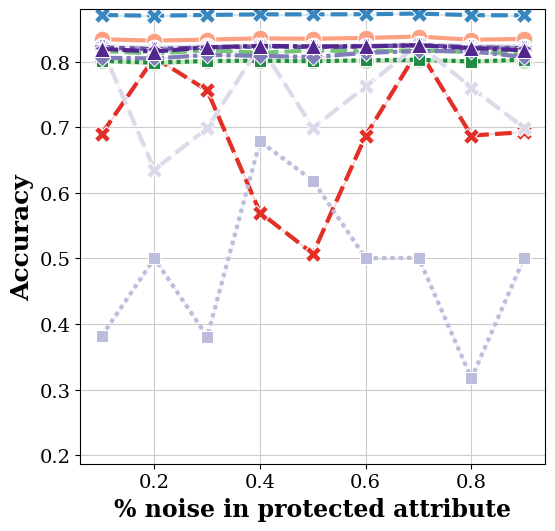

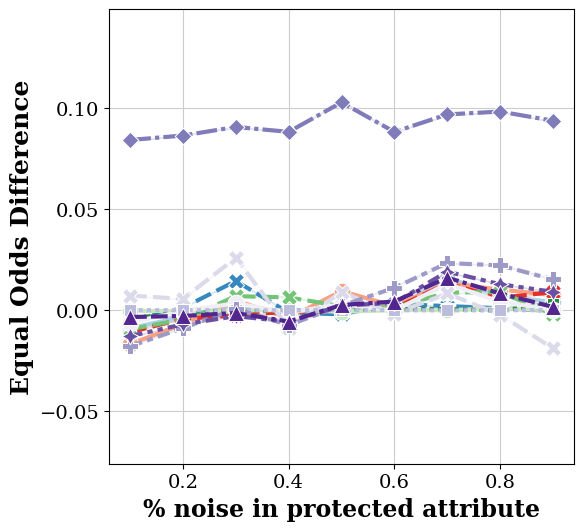

In [42]:
mpl.rcParams['figure.figsize'] = (6,9)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
algs = set(groupsizedf['algorithm'])
cons = list(set(groupsizedf['Constraints']))
cons.sort()
import pickle

pals = ['Blues','Reds','Greens','Purples']

for group,mdf in groupsizedf.groupby('metric'):
#     print(group)
    ax1 = None
    fig = plt.figure(1)

    for con,pal in zip(cons,pals):
#         print(con)
        df_group = mdf[mdf['Constraints']==con]
        df_group = df_group.reset_index(drop=True)
        mnv = min(mdf['value'])
        mxv = max(mdf['value'])

        ax1 = sns.lineplot(data=df_group, x="percentage", y="value", ci = 0, markersize = 12, palette = pal,
                          linewidth = 3, markers = True, style="algorithm", hue="algorithm") #dashes=style
#         ax2 = sns.lineplot(data=df_group, x="percentage", y="value", ci = 0, markersize = 12, palette = pal,
#                           linewidth = 3, markers = True, style="algorithm", hue="algorithm") #dashes=style
    #     plt.title(group)
        plt.legend(loc=(1.05, 0))
        plt.xlabel("% noise in protected attribute",fontsize=17,weight='bold')
        plt.ylabel(group,fontsize=18,weight='bold')

        ax1.xaxis.grid(True,which='both')
        ax1.yaxis.grid(True,which='both')
        
        ax1.set_ylim(mnv, mxv)


        ax1.set_facecolor('white')
        ax1.tick_params(axis='y', which='both',labelsize=14)
        ax1.tick_params(axis='x', which='both',labelsize=14)
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        
        legend_properties = {'weight':'bold','size': 14}


        # Put a legend below current axis
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), prop = legend_properties,
                  fancybox=True, shadow=False, ncol=len(set(df_group.algorithm)))
        ax1.get_legend().remove()

        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     plt.savefig('Plots2/diabetes_synthetic_genderflip_'+group+'.pdf', pad_inches = 0,bbox_inches = "tight")
    with open('Plots2/lsac_'+group+'.pkl', 'wb') as file:
        pickle.dump(fig, file)

    plt.show()
    plt.close(fig)

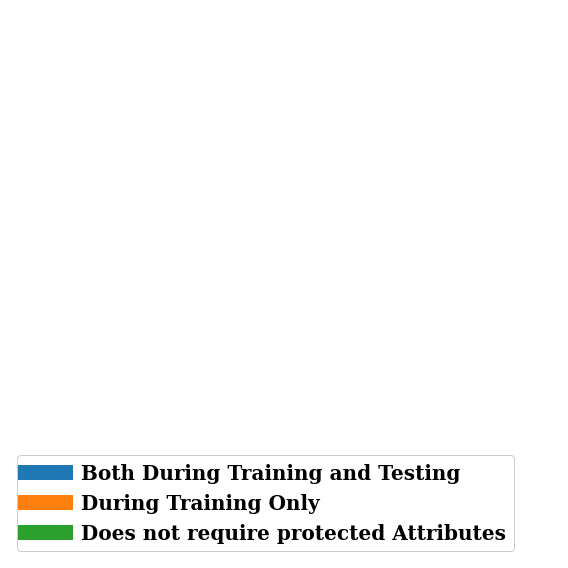

In [217]:
handles = []
colors = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
for cl in colors:
    handles.append(mpl.lines.Line2D(xdata=[],ydata=[],color=cl,linewidth=15))

labels = ['Both During Training and Testing', 'During Training Only', 'Does not require protected Attributes']
# labels.extend(mstyle.keys())
ax.clear()
plt.clf()
plt.cla()
plt.close()

legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=1,facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
    hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig  = legend.figure
expand=[-5,-5,5,5]
fig.canvas.draw()
plt.tight_layout()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
plt.savefig('Plots/legend1.pdf', bbox_inches = "tight",pad_inches = 0)

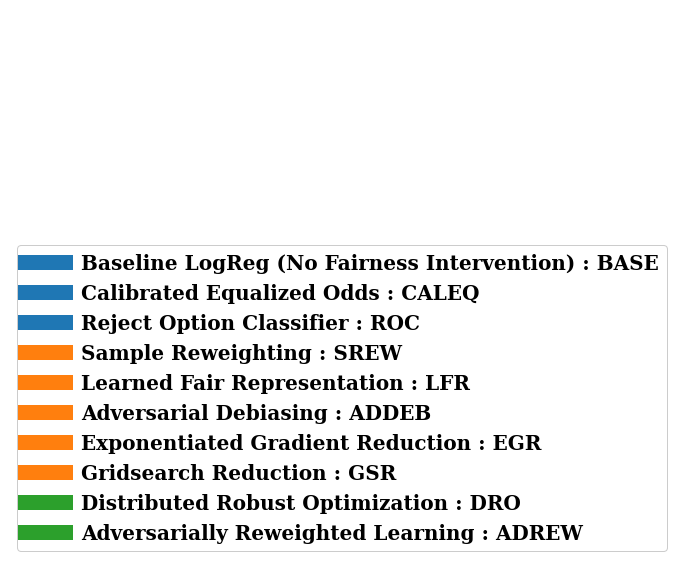

In [218]:
handles = []
colors = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
labels = [a+' : '+b for a, b in zip(namedic.values(),namedic2.values())]
mcols = [colors[0],colors[0],colors[0],colors[1],colors[1],colors[1],colors[1],colors[1],colors[2],colors[2]]
for m,cl in zip(namedic.values(),mcols):
    handles.append(mpl.lines.Line2D(xdata=[],ydata=[],color=cl,linewidth=15))#,marker=mstyle[m],markersize=10))

# labels.extend(mstyle.keys())
ax.clear()
plt.clf()
plt.cla()
plt.close()

legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=1,facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
    hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig  = legend.figure
expand=[-5,-5,5,5]
fig.canvas.draw()
plt.tight_layout()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
plt.savefig('Plots/legend2.pdf', bbox_inches = "tight",pad_inches = 0)

In [152]:
list(mstyle.keys())

['Baseline LogReg (No Fairness Intervention)',
 'Calibrated Equalized Odds',
 'Reject Option Classifier',
 'Sample Reweighting',
 'Learned Fair Representation',
 'Adversarial Debiasing',
 'Exponentiated Gradient Reduction',
 'Gridsearch Reduction',
 'Distributed Robust Optimization',
 'Adversarially Reweighted Learning']

In [102]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'  
i = 0

for metric in set(df_temps['metric']):
    text = r'''\xsubfigure{'''+letters[i]+r'''}{
          width=0.24\textwidth,
          body={\includegraphics[width=\columnwidth,keepaspectratio]{figures/adult_casestudy__'''+metric+r'''.pdf}},
          caption={"'''+metric+'''"}
        }'''
    i+=1
    print(text)

\xsubfigure{A}{
          width=0.24\textwidth,
          body={\includegraphics[width=\columnwidth,keepaspectratio]{figures/adult_casestudy__Equal Opportunity Difference.pdf}},
          caption={"Equal Opportunity Difference"}
        }
\xsubfigure{B}{
          width=0.24\textwidth,
          body={\includegraphics[width=\columnwidth,keepaspectratio]{figures/adult_casestudy__True Positive Rate Difference.pdf}},
          caption={"True Positive Rate Difference"}
        }
\xsubfigure{C}{
          width=0.24\textwidth,
          body={\includegraphics[width=\columnwidth,keepaspectratio]{figures/adult_casestudy__Disparate Impact Ratio.pdf}},
          caption={"Disparate Impact Ratio"}
        }
\xsubfigure{D}{
          width=0.24\textwidth,
          body={\includegraphics[width=\columnwidth,keepaspectratio]{figures/adult_casestudy__Accuracy.pdf}},
          caption={"Accuracy"}
        }
\xsubfigure{E}{
          width=0.24\textwidth,
          body={\includegraphics[width=\column